In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import math
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from fastdtw import fastdtw
from sklearn.decomposition import PCA
sys.path.append('../../../..')
from glob import glob
from multiprocessing import Queue
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from bayes_opt import BayesianOptimization
from tensorflow.python.client import device_lib
from joblib import Parallel, delayed

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7690455144581252704
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22712156160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4015729749940561536
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
# Calculagraph
start_time = time.time()

In [4]:
# Parameters
train_index = '1'
model_name = 'Voformer_20120608_precipitation'
batch_size = 15                 # Batch size of train input data
epoch = 100                     # Train epochs
process_num = 10                 # Experiments times
initial_learning_rate = 0.01    # Initial learning rate
decay_steps = 10000             # Decay steps
decay_rate = 0.5                # Decay rate
warmup_step = 10000            # Warm up steps
warm_power = 0.1                # The rate at which the learning rate decreases
save_step = 1                   # How many times to train to save
training = False               # Whether to train or save the model

pre_train_input = Queue(maxsize=batch_size * batch_size)  # Preprocess the data, extract features
pre_train_input_batch = Queue(maxsize=batch_size)  # Integrate preprocessed data
# Model structure
pb_path = f'./{model_name}'

# Extreme Clustering

In [5]:
def Extreme_Clustreing(data, neighbuorhood_radius=0.2):
    data = np.array(data)  # Convert the list to a NumPy array
    number = data.shape[0]
    dim = data.shape[1]
    dist1 = pdist(data,metric='euclidean') # Elements fastdtw distance
    dist = squareform(dist1) # Euclidean distance symmetric matrix
    c = np.ones((number, number), dtype=int)
    b = dist
    for cow in range(number):
        c[cow] = np.argsort(b[cow]) # Original data each elements euclidean distance index
        b[cow] = np.sort(dist[cow]) # Original data each dataset sequence sort

    # Computting density
    # Gaussian Kernel Density Estimation
    position = np.round((number)*0.013) - 1
    dist = squareform(dist1)
    sda = np.sort(dist,axis = 0)
    cow = (int)(position%number)
    column = (int)(position/number)
    dc = sda[cow,column]
    density = np.zeros((number))
    # Gaussian kernel calculation
    for i in range(number-1):
        for j in range(i+1,number):
            density[i] = density[i] + np.exp(-(dist[i,j]/dc)*(dist[i,j]/dc))
            density[j] = density[j] + np.exp(-(dist[i,j]/dc)*(dist[i,j]/dc))

    # Searching for extreme points
    # Initialisation
    extremePoint = np.zeros((number, dim + 1))
    extremePoint_num = 0
    state = np.zeros((number), dtype=int)
    for i in range(number):
        if i > number/2:
            break
        if state[i] == 0:
            # Traverse all density, whether there is a point with a density greater than the current point and neighbuorhood_radiu.
            j = 1
            while density[i] >= density[c[i, j]] and b[i, j] < neighbuorhood_radius:
                if density[i] == density[c[i, j]]:
                    state[c[i, j]] = 1
                j += 1
                if j == number:
                    break
            if j == number:
                j = number - 1
            ## Dataset[i] >= Neighbuorhood_radius, then it's a extreme point
            if b[i, j] >= neighbuorhood_radius:
                extremePoint_num += 1
                extremePoint[extremePoint_num - 1, 0:dim] = data[i, 0:dim]
                extremePoint[extremePoint_num - 1, dim] = i

    # Assigning category
    # Initialisation
    clustering_result = np.zeros((number), dtype=int)
    for i in range(extremePoint_num):
        clustering_result[(int)(extremePoint[i][dim])] = i + 1
        j = 1
        # Traverse all dataset distance, search to assign extreme point to be a knot
        while b[(int)(extremePoint[i][dim])][j] < neighbuorhood_radius:
            # If the density of the current point equal to the most density that the data sequence where that point lies, then it's a knot
            if density[(int)(extremePoint[i][dim])] == density[c[(int)(extremePoint[i][dim]), j]]:
                clustering_result[c[(int)(extremePoint[i][dim]), j]] = i + 1
            j += 1
    for i in range(number):
        if clustering_result[i] == 0:
            queue = np.zeros((number), dtype=int)
            s = 0
            queue[s] = i
            while True:
                j = 0
                # Verify whether the current point is the density maximum
                while density[queue[s]] >= density[c[queue[s], j]]:
                    j += 1
                    if j == number:
                        j = number - 1
                        break
                # Verify whether the current point is the cluster knot
                if clustering_result[c[queue[s]][j]] == 0:
                    s += 1
                    queue[s] = c[queue[s - 1]][j]
                else:
                    break
                if s == number - 1:
                    s = number - 2
                    break
            # Assign cluster point labels
            for t in range(s + 1):
                clustering_result[queue[t]] = clustering_result[c[queue[s]][j]]

    # Detecting noises
    # Initialisation
    num = np.zeros((extremePoint_num))
    for i in range(number):
        num[clustering_result[i] - 1] += 1 # Recording each clustering group member amount
    num_mean = np.mean(num)
    # Detect noises, because its number is too rare, in statistics, such observations are generally included as invalid values
    for i in range(extremePoint_num):
        if num[i] < num_mean * 0.05:
            for j in range(number):
                if clustering_result[j] == i + 1:
                    clustering_result[j] = -1 # Invalid values label '-1' e.g. noise
    # Make the categories in the clustering results continuous values
    sortNum = 0
    sortNumMax = np.max(clustering_result)

    clustering = -np.ones((number), dtype=int)
    for i in range(sortNumMax):
        flag = 0
        for j in range(number):
            if clustering_result[j] == i + 1:
                flag = 1
                break
        if flag == 1:
            sortNum += 1
            for j in range(number):
                if clustering_result[j] == i + 1:
                    clustering[j] = sortNum
    clustering_result = clustering
    return clustering_result

In [6]:
# Clustering result two-dimension picture display
def Visualization(data, clusteringResult, isShowNoise=False):
    number = data.shape[0]
    color = ['#278EA5', '#21E6C1', '#FFBA5A', '#FF7657', '#C56868', '#6b76ff', '#ff0000', '#9e579d', '#f85f73'
        , '#928a97', '#b6f7c1', '#0b409c', '#d22780', '#882042', '#071E3D']
    lineForm = ['o', '+', '*', 'x']
    if data.shape[1] > 2:
        pca = PCA(n_components=2)
        data = pca.fit_transform(data)
    for i in range(np.max(clusteringResult)):
        Together = []
        flag = 0
        for j in range(number):
            if clusteringResult[j] == i + 1:
                flag += 1
                Together.append(data[j])
        Together = np.array(Together)
        colorNum = np.mod(i + 1, 15)
        formNum = np.mod(i + 1, 4)
        plt.scatter(Together[:, 0], Together[:, 1], 15, color[colorNum], lineForm[formNum])

    plt.xlabel('attribute 1', fontsize=10)
    plt.ylabel('attribute 2', fontsize=10)
    plt.title('Extreme clustering')
    if isShowNoise == True:
        Together = []
        flag = 0
        for j in range(number):
            if clusteringResult[j] == -1:
                flag += 1
                Together.append(data[j])
        Together = np.array(Together, dtype=int)
        if Together.shape[0] != 0:
            plt.scatter(Together[:, 0], Together[:, 1], 15, 'k', '.')
    plt.show()

# Voformer Model

In [7]:
class StuModel:
    def __init__(self, nums=10000, training=True):
        self.nums = nums
        self.training = training
        self.input_data = layers.Input(shape=[276], name='input_data')
        self.input_position = layers.Input(shape=[None, 256], name='input_position', dtype=tf.float32)
        self.label_em_ids = layers.Input(shape=[None], name='label_em_ids', dtype=tf.int64)
        self.label_position = layers.Input(shape=[None, 256], name='label_position', dtype=tf.float32)
        self.decoder_encoder_input = layers.Input(shape=[None, 256], name='decoder_encoder_input')
        self.decoder_label = layers.Embedding(self.nums, 256, name='decoder_label')
        model_output = self.a_model()
        inputs = [self.input_data, self.input_position, self.label_em_ids, self.label_position]
        outputs = [model_output]
        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)
        self.model.summary()

    def a_model(self):
        self.time_feature = layers.Embedding(max_index + 1, 256, name='time_feature')
        encoder_input = self.time_feature(self.input_data)
        encoder_input = layers.Add()([encoder_input, self.input_position])
        encoder_input = layers.Dropout(0.1)(encoder_input)
        encoder_result, encoder_result_all = self.tr_encoder(encoder_input)
        encoder_result = layers.LayerNormalization(epsilon=1e-5)(encoder_result)
        self.encoder_result = encoder_result

        if not self.training:
            decoder_encoder_input = self.decoder_encoder_input
        else:
            decoder_encoder_input = self.encoder_result

        decoder_input = self.decoder_label(self.label_em_ids)
        decoder_input = layers.Add()([decoder_input, self.label_position])
        decoder_input = layers.Dropout(0.1)(decoder_input)
        decoder_result, decoder_result_all = self.tr_decoder(decoder_input, decoder_encoder_input)
        decoder_result = layers.LayerNormalization(epsilon=1e-5)(decoder_result)
        model_output = layers.Dense(units=self.nums, name='model_output')(decoder_result)
        decoder_output = layers.Softmax(name='decoder_output')(model_output)
        return decoder_output

    def _prob_QK(self, Q, K):  # n_top: c*ln(L_q)
        B, H, L_K, E = K.shape
        _, _, L_Q, _ = Q.shape
        K_expand = tf.tile(tf.expand_dims(K, -3), [1, 1, L_K, 1, 1])
        index_sample = np.random.randint(1, L_Q)  # real U = U_part(factor*ln(L_k))*L_q
        K_sample = K_expand[:, :, :, index_sample, :]
        Q_K_sample = tf.matmul(Q, tf.transpose(K_sample, [0, 1, 3, 2]))
        return Q_K_sample

    def _update_context(self, context_in, V, scores, index, L_Q, attn_mask):
        B, H, L_V, D = V.shape
        attn = tf.nn.softmax(scores, dim=-1)  # nn.Softmax(dim=-1)(scores)
        context_in[np.arange(B)[:, None, None],
        np.arange(H)[None, :, None],
        index, :] = tf.matmul(attn, V).type_as(context_in)
        return (context_in, None)

    def tr_encoder(self, encoder_input,
                   hidden_size=256,
                   head_num=4,
                   hidden_layer_num=26,
                   intermediate_size=2048):
        if hidden_size % head_num != 0:
            raise ValueError(f'hidden_size:{hidden_size} num_attention_heads:{head_num}')
        head_dim = int(hidden_size / head_num)
        all_layer_outputs = []
        for layer_idx in range(hidden_layer_num):
            # encoder-Pro self-attention
            residual = encoder_input
            encoder_output = layers.LayerNormalization(epsilon=1e-5)(encoder_input)
            query, key, value = self.compute_qkv(name=f'encoder_qkv_{layer_idx}', query=encoder_output,
                                                 key=encoder_output, value=encoder_output, head_num=head_num,
                                                 head_dim=head_dim)
            self.factor = 5
            L_K = key.shape[1]
            L_Q = query.shape[1]
            U_part = self.factor * np.ceil(np.log(L_K)).astype('int').item()  # c*ln(L_k)
            u = self.factor * np.ceil(np.log(L_Q)).astype('int').item()  # c*ln(L_q)
            U_part = U_part if U_part < L_K else L_K
            u = u if u < L_Q else L_Q
            scores_top = self._prob_QK(query, key)
            context = tf.cumsum(value, -2)
            encoder_output = tf.matmul(scores_top, context)
            encoder_output = tf.reshape(encoder_output, [-1, encoder_output.shape[1],
                                                         encoder_output.shape[2] * encoder_output.shape[3]])
            # scores = self.compute_score(query=query, key=key, head_dim=head_dim)
            # encoder_attention_mask = tf.expand_dims(tf.expand_dims(encoder_mask, 1), 1)
            # encoder_output = self.compute_attention_result(value=value, scores=scores, mask=encoder_attention_mask,
            #                                                head_num=head_num, head_dim=head_dim)
            encoder_output = layers.Dense(units=hidden_size, kernel_initializer='he_normal')(encoder_output)
            encoder_output = layers.Dropout(0.1)(encoder_output)
            encoder_output = layers.Add()([residual, encoder_output])
            # encoder-feed-forward
            residual = encoder_output
            encoder_output = layers.LayerNormalization(epsilon=1e-5)(encoder_output)
            encoder_output = layers.Dense(units=intermediate_size, kernel_initializer='he_normal')(encoder_output)
            # encoder_output = layers.ReLU()(encoder_output)
            encoder_output = self.volatilite(encoder_output)
            encoder_output = layers.Dropout(0.1)(encoder_output)
            encoder_output = layers.Dense(units=hidden_size, kernel_initializer='he_normal')(encoder_output)
            encoder_output = layers.Add()([residual, encoder_output])
            encoder_input = encoder_output
            all_layer_outputs.append(encoder_output)
        return all_layer_outputs[-1], all_layer_outputs

    def tr_decoder(self, decoder_input,
                   encoder_result,
                   hidden_size=256,
                   head_num=4,
                   hidden_layer_num=26,
                   intermediate_size=2048):
        if hidden_size % head_num != 0:
            raise ValueError(f'hidden_size:{hidden_size} num_attention_heads:{head_num}')
        head_dim = int(hidden_size / head_num)
        all_layer_outputs = []
        for layer_idx in range(hidden_layer_num):
            # decoder:self-attention
            residual = decoder_input
            decoder_output = layers.LayerNormalization(epsilon=1e-5)(decoder_input)
            query, key, value = self.compute_qkv(name=f'decoder_qkv_{layer_idx}', query=decoder_output,
                                                 key=decoder_output, value=decoder_output, head_num=head_num,
                                                 head_dim=head_dim)
            scores = self.compute_score(query=query, key=key, head_dim=head_dim)
            # The essence of the mask is to reduce the weight of the associated unit to approximately 0 during the attention. 
            # The encoder-mask mainly does not focus on non-existing units.
            # Decoder-self-mask，not only paying no attention to the non-existing unit, but also not pay attention to the unit after it.
            # Therefore, different mask information is configured for each unit.
            decoder_output = self.compute_attention_result(value=value, scores=scores,
                                                           head_num=head_num, head_dim=head_dim)
            decoder_output = layers.Dense(units=hidden_size, kernel_initializer='he_normal')(decoder_output)
            decoder_output = layers.Dropout(0.2)(decoder_output)
            decoder_output = layers.Add()([residual, decoder_output])

            # decoder:encoder-decoder attention
            residual = decoder_output
            decoder_output = layers.LayerNormalization(epsilon=1e-5)(decoder_input)
            query, key, value = self.compute_qkv(name=f'encoder-decoder_qkv_{layer_idx}', query=decoder_output,
                                                 key=encoder_result, value=encoder_result, head_num=head_num,
                                                 head_dim=head_dim)
            scores = self.compute_score(query=query, key=key, head_dim=head_dim)
            decoder_output = self.compute_attention_result(value=value, scores=scores,
                                                           head_num=head_num, head_dim=head_dim)
            decoder_output = layers.Dense(units=hidden_size, kernel_initializer='he_normal')(decoder_output)
            decoder_output = layers.Dropout(0.1)(decoder_output)
            decoder_output = layers.Add()([residual, decoder_output])

            # Fully connected layer
            residual = decoder_output
            decoder_output = layers.LayerNormalization(epsilon=1e-5)(decoder_input)
            decoder_output = layers.Dense(units=intermediate_size, kernel_initializer='he_normal')(decoder_output)
            # decoder_output = layers.ReLU()(decoder_output)
            decoder_output = self.volatilite(decoder_output)
            decoder_output = layers.Dropout(0.1)(decoder_output)
            decoder_output = layers.Dense(units=hidden_size, kernel_initializer='he_normal')(decoder_output)
            decoder_output = layers.Add()([residual, decoder_output])

            decoder_input = decoder_output
            all_layer_outputs.append(decoder_output)
        return all_layer_outputs[-1], all_layer_outputs

    def compute_qkv(self, name, query, key, value,
                    head_num,
                    head_dim):
        query_layer = layers.Dense(units=head_num * head_dim, kernel_initializer='he_normal',
                                   name=f'query_{name}')(query)
        key_layer = layers.Dense(units=head_num * head_dim, kernel_initializer='he_normal', name=f'key_{name}')(
            key)
        value_layer = layers.Dense(units=head_num * head_dim, kernel_initializer='he_normal',
                                   name=f'value_{name}')(value)
        query_layer = layers.Reshape([-1, head_num, head_dim])(query_layer)
        key_layer = layers.Reshape([-1, head_num, head_dim])(key_layer)
        value_layer = layers.Reshape([-1, head_num, head_dim])(value_layer)
        return query_layer, key_layer, value_layer

    def compute_score(self, query, key, head_dim):
        query = tf.transpose(query, [0, 2, 1, 3])  # [batch,head_num,time1,head_dim]
        key = tf.transpose(key, [0, 2, 3, 1])  # [batch,head_num,head_dim,time2]
        scores = tf.matmul(query, key)
        scores = tf.multiply(scores, 1.0 / math.sqrt(float(head_dim)))  # [batch,head_num,time1,time2]
        return scores

    def compute_attention_result(self, value, scores, head_num, head_dim):
        # When performing attention, only the current unit and weight of each unit are considered.
        # The non-existing units are not considered to have values, and all loss needs to be masked for non-existent units.
        scores = layers.Softmax()(scores)

        value = tf.transpose(value, [0, 2, 1, 3])  # [batch,head_num,time2,head_dim]
        attention_result = tf.matmul(scores, value)
        attention_result = tf.transpose(attention_result, [0, 2, 1, 3])  # [batch,time1,head_num,head_dim]
        attention_result = layers.Reshape([-1, head_num * head_dim])(
            attention_result)  # [batch,time1,head_num*head_dim]
        return attention_result

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)
        # Item 2i uses sin
        sines = np.sin(angle_rads[:, 0::2])
        # Item 2i+1 uses cos
        cones = np.cos(angle_rads[:, 1::2])
        pos_encoding = np.concatenate([sines, cones], axis=-1)
        pos_encoding = pos_encoding[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def gelu(self, x):
        cdf = 0.5 * (1.0 + tf.tanh(
            (np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3)))))
        return x * cdf

    def volatilite(self, x):
        x = tf.square(tf.reduce_mean(x, axis=1, keepdims=True) - x)
        x = tf.reduce_mean(x, axis=1)
        x = tf.sqrt(x)
        return x

def compute_loss(input_data, model_output):
    c_data = []
    for data in input_data:
        tmp_data = []
        for d in data:
            d_data = np.zeros(len(emb))
            d_data[d] = 1
            tmp_data.append(d_data)
        c_data.append(tmp_data)
    c_data = np.array(c_data)
    return tf.reduce_mean(-tf.multiply(c_data, tf.keras.backend.log(model_output + 1e-7)) - tf.multiply(
        (1 - c_data), tf.keras.backend.log(1 - model_output + 1e-7)))

def position_embedding(position, d_model):
    pos_encoding = np.zeros([position, d_model])
    position = np.expand_dims(np.arange(0, position, dtype=np.float32), 1)
    div_term = np.power(10000, -np.arange(0, d_model, 2, dtype=np.float32) / d_model)
    pos_encoding[:, 0::2] = np.sin(position * div_term)
    pos_encoding[:, 1::2] = np.cos(position * div_term)
    return pos_encoding

def chunks(arr_list, num):
    n = int(math.ceil(len(arr_list) / float(num)))
    return [arr_list[i:i + n] for i in range(0, len(arr_list), n)]

def load_frame(path):
    frame_names = {}
    for frame_name in glob(f'{path}/frame*'):
        name = os.path.split(frame_name)[1]
        if len(name.split('_')) == 2:
            frame_names[int(name.split('_')[1])] = frame_name

    if len(sorted(frame_names)) == 0:
        return None, None
    else:
        frame_index = sorted(frame_names)[-1]
        return frame_names[frame_index], frame_index

def delete_frame(path):
    frame_names = {}
    for frame_name in glob(f'{path}/frame*'):
        name = os.path.split(frame_name)[1]
        if len(name.split('_')) == 2:
            frame_names[int(name.split('_')[1])] = frame_name

    for delete_key in sorted(frame_names)[:-5]:
        os.remove(frame_names[delete_key])

# Voformer-EC Model training and clustering

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 276)]        0                                            
__________________________________________________________________________________________________
time_feature (Embedding)        (None, 276, 256)     292352      input_data[0][0]                 
__________________________________________________________________________________________________
input_position (InputLayer)     [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
add (Add)                       (None, 276, 256)     0           time_feature[0][0]               
                                                                 input_position[0][0]         

Restore Weight = ./Voformer_20120608_precipitation\frame_48
[ 1  2 53 ... 53 53 53]
Number=295


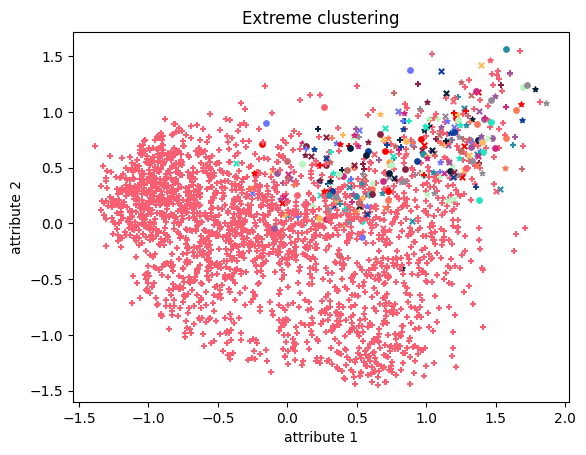

Elapsed time: 41.9300 seconds


SystemExit: 

D:\anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [8]:
datas = []
emb = []
with open('Precipitation 20120608.txt', 'r') as f:
    for line in f.readlines():
        tmp_list = []
        for l in line.split('\t')[1:]:
            tmp_list.append(float(l))
            emb.append(float(l))
        datas.append(tmp_list)
emb = list(set(emb))

train_data = []
for data in datas:
    train_data.append([emb.index(d) for d in data])
max_index = max([max(row) for row in train_data])

''' ----------------------------Load Model------------------------------- '''
if not os.path.exists(pb_path):
    os.makedirs(pb_path)

stu_train_model = None
stu = StuModel(len(emb))
# Restore weight
frame_path, frame_index = load_frame(path=pb_path)
if frame_path is None:
    global_step = 0
else:
    stu.model.load_weights(frame_path, by_name=True, skip_mismatch=False)
    global_step = frame_index
    print(f'Restore Weight = {frame_path}')
stu_train_model = stu.model

if not training:
    time_feature = stu_train_model.weights[0].numpy()
    time_feature_result = []
    for t_d in train_data:
        time_feature_result.append([time_feature[t] for t in t_d])

    embeddings = np.array(time_feature_result)

    # Feature dimension n*m*z
    embeddings_1=np.mean(embeddings,-2) # n*z
    embeddings_2 =np.reshape(embeddings,[len(embeddings),-1]) # n*(m*z)  
    # Perform clustering and visualization
    cluster_result=Extreme_Clustreing(embeddings_2,4)
    print(cluster_result)
    result=np.unique(cluster_result).shape[0]
    print("Number={}".format(result))
    Visualization(embeddings_2, cluster_result, False)
    cluster_result_df = pd.DataFrame(cluster_result, columns=['Cluster'])
    cluster_result_df.to_csv('F:/Desktop/PhD/Progress/weather data/precipitation documents/test_Precipitation 201206 result.csv', index=False)
    # End Timing
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.4f} seconds")
    sys.exit()


''' ------------------------Processing Data------------------------------ '''
position = position_embedding(1024, 256)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_learning_rate,
                                                             decay_steps=decay_steps,
                                                             decay_rate=decay_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

current_loss = 0

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

best_model_checkpoint = ModelCheckpoint(filepath=f'{pb_path}/best_model.h5',
                                        monitor='val_loss',
                                        save_best_only=True,
                                        mode='min',
                                        verbose=1)

min_loss = np.inf
patience = 20
counter = 0

for e_data in chunks(train_data, int(len(train_data) / batch_size)):
    start_time = time.time()
    position_e = np.array([position_embedding(276, 256) for i in range(len(e_data))])
    input_data = np.array(e_data)
    # Gradient descent
    with tf.GradientTape(persistent=False) as tape:
        try:
            model_output = stu_train_model(
                [input_data, position_e, input_data, position_e],
                training=training)

        except Exception as e:
            print(e)
            continue
        second_time = time.time()
        total_loss = compute_loss(input_data, model_output)
        third_time = time.time()

    grads = tape.gradient(target=total_loss, sources=stu_train_model.trainable_variables)
    # Gradient clipping
    # for i, grad in enumerate(grads):
    #     grads[i] = tf.clip_by_norm(grad, clip_norm=3)
    optimizer.apply_gradients(zip(grads, stu_train_model.trainable_variables))
    global_step = global_step + 1
    print(f'Current{global_step}的total_loss = {total_loss} ')
    fourth_time = time.time()

    if total_loss < min_loss:
        min_loss = total_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        break

    if global_step % save_step == 0:
        stu_train_model.save(f'{pb_path}/frame_{global_step}', save_format='h5')
        delete_frame(pb_path)
        print(f'Save the model to{pb_path}')

stu_train_model.save(f'{pb_path}/frame_{global_step}', save_format='h5')
delete_frame(pb_path)
print(f'Save the model and the training is complete!')
sys.exit()

In [9]:
# Load data
data = embeddings_2
# Within-cluster SS (inertia)
def within_cluster_ss(X, labels, centroids):
    inertia = 0
    for i in range(len(centroids)):
        inertia += np.sum((X[labels == i] - centroids[i]) ** 2)
    return inertia


def mean_distance_to_nearest_cluster_member(X, labels):
    unique_labels = np.unique(labels)
    mean_distances = []
    
    for label in unique_labels:
        cluster_points = X[labels == label]
        if len(cluster_points) > 1:
            distances = pairwise_distances(cluster_points)
            np.fill_diagonal(distances, np.inf)
            min_distances = np.min(distances, axis=1)
            mean_distances.append(np.mean(min_distances))
    
    return np.mean(mean_distances)

def dunn_index(X, labels, centroids):
    unique_labels = np.unique(labels)
    num_clusters = len(unique_labels)
    inter_cluster_dists = pdist(centroids, 'euclidean')
    inter_cluster_dists = squareform(inter_cluster_dists)
    np.fill_diagonal(inter_cluster_dists, np.inf)

    min_inter_cluster_dist = np.min(inter_cluster_dists)

    max_intra_cluster_dist = 0
    for i in range(num_clusters):
        cluster_points = X[labels == i]
        
        if len(cluster_points) == 0:  # Skip empty clusters
            continue
        
        intra_cluster_dists = pdist(cluster_points, 'euclidean')
        
        if len(intra_cluster_dists) == 0:  # If there's only one point in the cluster, max distance should be 0
            max_dist = 0
        else:
            max_dist = np.max(intra_cluster_dists)
        
        if max_dist > max_intra_cluster_dist:
            max_intra_cluster_dist = max_dist

    dunn = min_inter_cluster_dist / max_intra_cluster_dist
    return dunn

# Calculate centroids
def get_centroids(data, labels):
    unique_labels = np.unique(labels)
    centroids = np.zeros((len(unique_labels), data.shape[1]))
    
    for i, label in enumerate(unique_labels):
        cluster_points = data[labels == label]
        centroids[i] = np.mean(cluster_points, axis=0)
    
    return centroids

centroids = get_centroids(data, cluster_result)

# Calculate evaluation indices
inertia = within_cluster_ss(data, cluster_result, centroids)
silhouette = silhouette_score(data, cluster_result)
davies_bouldin = davies_bouldin_score(data, cluster_result)
calinski_harabasz = calinski_harabasz_score(data, cluster_result)
dunn = dunn_index(data, cluster_result, centroids)
mean_distance = mean_distance_to_nearest_cluster_member(data, cluster_result)

# Print evaluation indices
print(f'Silhouette Score: {silhouette}')
print(f'Calinski-Harabasz Index: {calinski_harabasz}')
print(f'Davies-Bouldin Index: {davies_bouldin}')
print(f'Within-cluster SS (Inertia): {inertia}')
print(f'Dunn Index: {dunn}')
print(f'Mean Distance to Nearest Cluster Member: {mean_distance}')

Silhouette Score: -0.015310685150325298
Calinski-Harabasz Index: 1.5545350180099937
Davies-Bouldin Index: 0.8185141786700803
Within-cluster SS (Inertia): 60291.90290299094
Dunn Index: 0.519773267634271
Mean Distance to Nearest Cluster Member: 4.886647701263428


i value for maximum Silhouette Score: 51
i value for maximum Calinski-Harabasz Score: 49
i value for maximum Within-Cluster SS (Inertia): 48
i value for minimum Davies-Bouldin Score: 48
i value for minimum Mean Distance to Nearest Cluster Member: 25


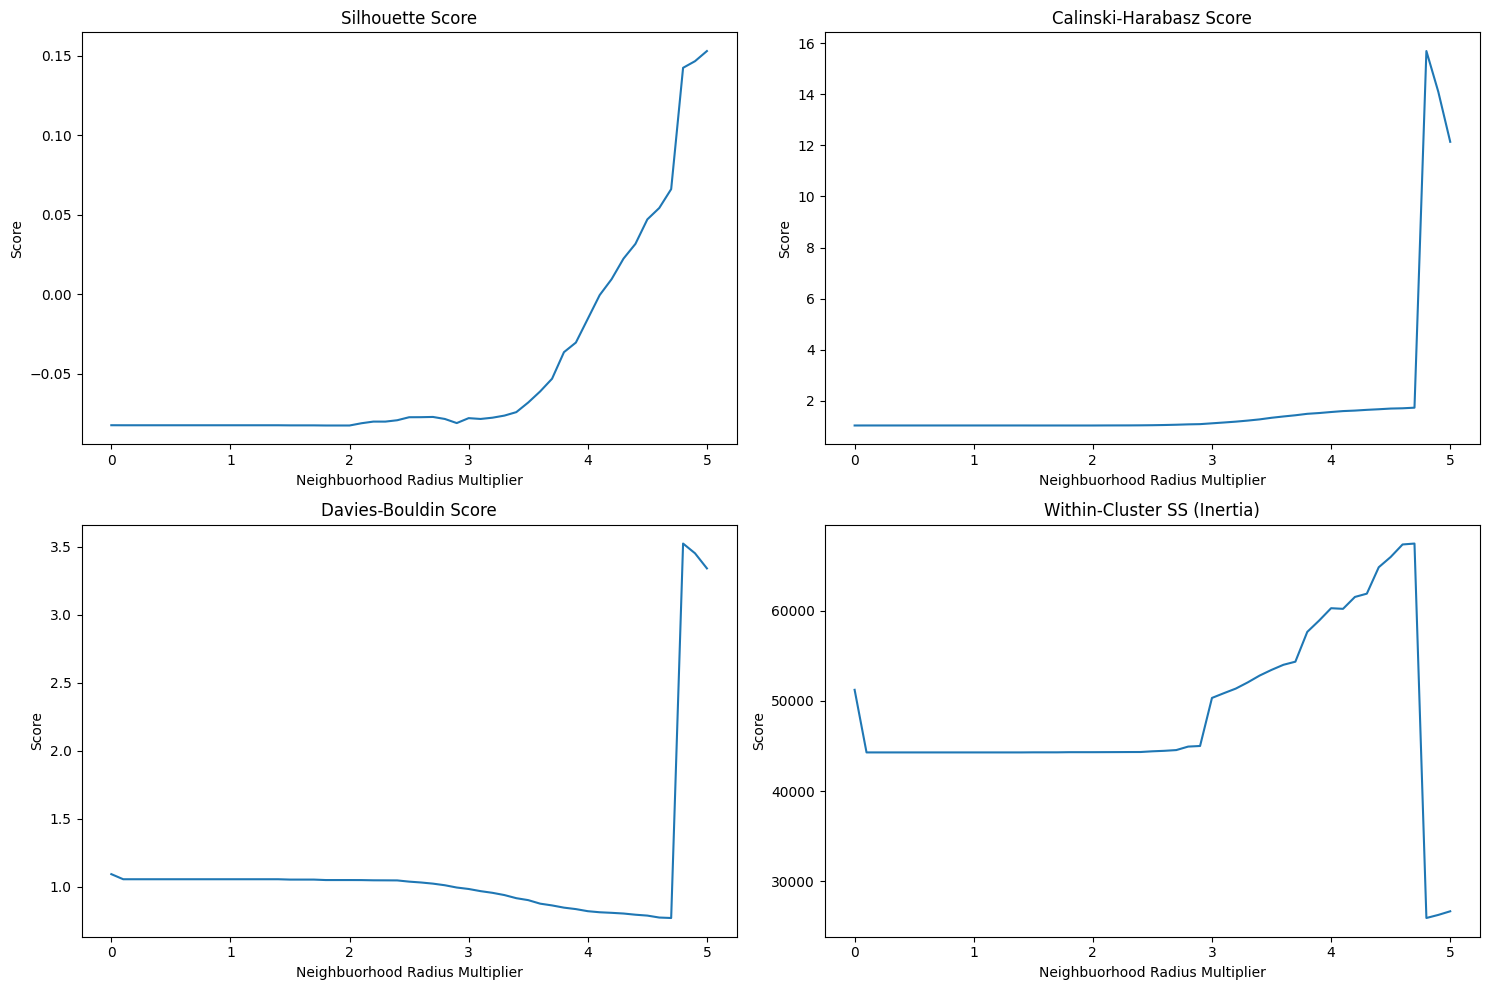

In [10]:
max_k = 50
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
within_cluster_sses = []
mean_distance_scores = []

def calculate_scores(k):
    cluster_result = Extreme_Clustreing(data, neighbuorhood_radius=k*0.1)
    unique_labels = np.unique(cluster_result)
    centroids = [np.mean(data[cluster_result == label], axis=0) for label in unique_labels]

    silhouette = silhouette_score(data, cluster_result)
    calinski_harabasz = calinski_harabasz_score(data, cluster_result)
    davies_bouldin = davies_bouldin_score(data, cluster_result)
    within_cluster_ss_value = within_cluster_ss(data, cluster_result, centroids)
    mean_distance = mean_distance_to_nearest_cluster_member(data, cluster_result)

    return silhouette, calinski_harabasz, davies_bouldin, within_cluster_ss_value, mean_distance

# Setting CPU cores number
results = Parallel(n_jobs=-1)(delayed(calculate_scores)(k) for k in range(0, max_k + 1))

for silhouette, calinski_harabasz, davies_bouldin, within_cluster_ss_value, mean_distance in results:
    silhouette_scores.append(silhouette)
    calinski_harabasz_scores.append(calinski_harabasz)
    davies_bouldin_scores.append(davies_bouldin)
    within_cluster_sses.append(within_cluster_ss_value)
    mean_distance_scores.append(mean_distance)

# Find the indices of maximum Silhouette Score and Calinski-Harabasz Score, and minimum Davies-Bouldin Score
max_silhouette_index = np.argmax(silhouette_scores)
max_calinski_harabasz_index = np.argmax(calinski_harabasz_scores)
max_within_cluster_ss = np.argmax(within_cluster_sses)
min_davies_bouldin_index = np.argmin(davies_bouldin_scores)
min_mean_distance_index = np.argmin(mean_distance_scores)

# Print the i values
print("i value for maximum Silhouette Score:", max_silhouette_index + 1)
print("i value for maximum Calinski-Harabasz Score:", max_calinski_harabasz_index + 1)
print("i value for maximum Within-Cluster SS (Inertia):", max_within_cluster_ss + 1)
print("i value for minimum Davies-Bouldin Score:", min_davies_bouldin_index + 1)
print("i value for minimum Mean Distance to Nearest Cluster Member:", min_mean_distance_index + 1)

# Plot the performance metrics
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].plot([i * 0.1 for i in range(0, max_k + 1)], silhouette_scores)
axs[0, 0].set_title('Silhouette Score')
axs[0, 0].set_xlabel('Neighbuorhood Radius Multiplier')
axs[0, 0].set_ylabel('Score')

axs[0, 1].plot([i * 0.1 for i in range(0, max_k + 1)], calinski_harabasz_scores)
axs[0, 1].set_title('Calinski-Harabasz Score')
axs[0, 1].set_xlabel('Neighbuorhood Radius Multiplier')
axs[0, 1].set_ylabel('Score')

axs[1, 0].plot([i * 0.1 for i in range(0, max_k + 1)], davies_bouldin_scores)
axs[1, 0].set_title('Davies-Bouldin Score')
axs[1, 0].set_xlabel('Neighbuorhood Radius Multiplier')
axs[1, 0].set_ylabel('Score')

axs[1, 1].plot([i * 0.1 for i in range(0, max_k + 1)], within_cluster_sses)
axs[1, 1].set_title('Within-Cluster SS (Inertia)')
axs[1, 1].set_xlabel('Neighbuorhood Radius Multiplier')
axs[1, 1].set_ylabel('Score')

plt.tight_layout()
plt.show()

In [11]:
# The scores of the four indicators when the Davies-Bouldin Score is the smallest
min_davies_bouldin_index = np.argmin(davies_bouldin_scores)
silhouette_score_at_min_db = silhouette_scores[min_davies_bouldin_index]
calinski_harabasz_at_min_db = calinski_harabasz_scores[min_davies_bouldin_index]
within_cluster_ss_at_min_db = within_cluster_sses[min_davies_bouldin_index]
min_mean_distance_index = np.argmin(mean_distance_scores)

# Print the i values
print("Silhouette Score when the Davies-Bouldin Score is the smallest:", silhouette_score_at_min_db)
print("Calinski-Harabasz Score when the Davies-Bouldin Score is the smallest:", calinski_harabasz_at_min_db)
print("Within-Cluster SS (Inertia) when the Davies-Bouldin Score is the smallest:", within_cluster_ss_at_min_db)
print("Minimum Davies-Bouldin Score:", davies_bouldin_scores[min_davies_bouldin_index])
print("Minimum Mean Distance to Nearest Cluster Member:", mean_distance_scores[min_mean_distance_index])

Silhouette Score when the Davies-Bouldin Score is the smallest: 0.06625337
Calinski-Harabasz Score when the Davies-Bouldin Score is the smallest: 1.7241615418440015
Within-Cluster SS (Inertia) when the Davies-Bouldin Score is the smallest: 67465.83932495117
Minimum Davies-Bouldin Score: 0.7683833374996578
Minimum Mean Distance to Nearest Cluster Member: 4.3553214
